In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from pandas.api.types import CategoricalDtype
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
import os
import matplotlib.pyplot as plt 
import plotly.express as px
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
mcu_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/mcu_org_data.csv")
mcu_data

,timestamp,NO2,PM10,PostCodes,date,hour
0,01-01-2020 00:00:00,56.77936,26.70000,M1 7EL,2020-01-01,0
1,01-01-2020 00:00:00,17.40000,36.37986,M25 9PJ,2020-01-01,0
2,01-01-2020 00:00:00,24.20000,52.00552,M28 2AB,2020-01-01,0
3,01-01-2020 00:00:00,17.97500,18.00549,M30 0DF,2020-01-01,0
4,01-01-2020 00:00:00,12.60000,31.02157,M32 8WB,2020-01-01,0
...,...,...,...,...,...,...
89429,31-12-2019 23:00:00,28.00000,38.80226,M32 9HR,2019-12-31,23
89430,31-12-2019 23:00:00,21.25600,23.87470,M45 8GW,2019-12-31,23
89431,31-12-2019 23:00:00,34.00236,17.70000,SK14 8LZ,2019-12-31,23
89432,31-12-2019 23:00:00,18.40000,32.68997,SK7 4BA,2019-12-31,23


In [5]:
#PM10 data of MCU
mcu_pm10 = mcu_data.drop('PostCodes', 1)
mcu_pm10 = mcu_pm10.drop('NO2', 1)
#mcu_pm10 = mcu_pm10.sort_values(by=['timestamp'],ascending=True)
mcu_pm10

,timestamp,PM10,date,hour
0,01-01-2020 00:00:00,26.70000,2020-01-01,0
1,01-01-2020 00:00:00,36.37986,2020-01-01,0
2,01-01-2020 00:00:00,52.00552,2020-01-01,0
3,01-01-2020 00:00:00,18.00549,2020-01-01,0
4,01-01-2020 00:00:00,31.02157,2020-01-01,0
...,...,...,...,...
89429,31-12-2019 23:00:00,38.80226,2019-12-31,23
89430,31-12-2019 23:00:00,23.87470,2019-12-31,23
89431,31-12-2019 23:00:00,17.70000,2019-12-31,23
89432,31-12-2019 23:00:00,32.68997,2019-12-31,23


In [6]:
mcu_pm10_df = mcu_pm10[(mcu_pm10['date'] <= '2019-12-31')]
mcu_pm10_df = mcu_pm10_df.sort_values(by=['date'], ascending=True)
mcu_pm10_df

,timestamp,PM10,date,hour
1524,01-07-2019 00:00:00,31.70000,2019-07-01,0
1690,01-07-2019 15:00:00,1.83985,2019-07-01,15
1691,01-07-2019 15:00:00,8.96050,2019-07-01,15
1692,01-07-2019 15:00:00,24.11602,2019-07-01,15
1693,01-07-2019 15:00:00,6.86069,2019-07-01,15
...,...,...,...,...
89279,31-12-2019 08:00:00,68.66377,2019-12-31,8
89280,31-12-2019 08:00:00,33.23361,2019-12-31,8
89281,31-12-2019 08:00:00,43.34884,2019-12-31,8
89269,31-12-2019 07:00:00,47.77971,2019-12-31,7


In [7]:
#df = mcu_df.rename(columns = {"date":"ds","PM10":"y"}) 
#df['day'] = pd.to_datetime(df['ds']).dt.date
df_pm10 = mcu_pm10_df.groupby(["date"])['PM10'].mean().reset_index()
df_pm10 = df_pm10.rename(columns = {"date":"ds","PM10":"y"}) 
df_pm10

,ds,y
0,2019-07-01,12.513731
1,2019-07-02,17.789500
2,2019-07-03,21.921510
3,2019-07-04,18.825590
4,2019-07-05,14.180656
...,...,...
179,2019-12-27,36.929280
180,2019-12-28,25.552343
181,2019-12-29,23.322168
182,2019-12-30,35.587796


In [8]:
## complete FB_Prophet fitting, plotting ETS components from model, finding performance metrics using cross validation and returing horizon based cross validation metrics on 
## a single training dataset -  cross validated on testing data only
def predict_FB_step1(df,break_index, per):
    df_FB = df[:break_index]
    print('start and end date of training dataset :', df_FB['ds'].head(1),df_FB['ds'].tail(1))
    
    test = df[break_index:break_index+per]
    print('start and end date of testing dataset :', test['ds'].head(1),test['ds'].tail(1))  
    print(test)
    
    from fbprophet import Prophet
    #The Prophet class (model)
    fbp = Prophet(daily_seasonality = True) 
    #Fit the model 
    fbp.fit(df_FB)
    
    # We need to specify the number of days in future
    # We'll be predicting the full 2021 stock prices
    fut = fbp.make_future_dataframe(periods=per) 
    forecast = fbp.predict(fut)
    
    from fbprophet.plot import plot_plotly, plot_components_plotly
    # A better plot than the simple matplotlib
    forecast_plot = plot_plotly(fbp, forecast)
    forecast_plot.show()
    
    fbp.plot(forecast)
    plt.title("Prediction of air quality")
    plt.xlabel("Date")
    plt.ylabel("value")
    plt.show()
    
    fbp.plot_components(forecast)
    plt.show()
    
    from statsmodels.tools.eval_measures import rmse
    predictions = forecast.tail(per)
    
    #predictions = forecast.iloc[-per:]['yhat']
    print(predictions['yhat'],test['y'])
    

    
    
    # Plot predictions against known values
    import matplotlib.ticker as ticker
    #formatter = ticker.StrMethodFormatter('{x:,.0f}')
    title = 'Air Quality forecast of PM10 using FB Prophet'
    ylabel='value'
    xlabel='Total days'
    ax = test['y'].plot(legend=True,figsize=(12,6),title=title)
    predictions['yhat'].plot(legend=True)
    ax.autoscale(axis='x',tight=True)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    #ax.yaxis.set_major_formatter(formatter);
    
    from fbprophet.diagnostics import cross_validation,performance_metrics
    from fbprophet.plot import plot_cross_validation_metric
    
    length = round(len(df_FB)/24,0)
    print(length)
    
    # Initial length of df_FB training period
    initial = 80
    initial = str(initial) + ' days'
    # Fold every length of df_FB years
    period = 10
    period = str(period) + ' days'
    # Forecast per days into the future
    horizon = per
    horizon = str(horizon) + ' days'
    #, 
    df_cv = cross_validation(fbp,initial=initial, period=period,  horizon = horizon)
    df_cv
    performance_metrics = performance_metrics(df_cv)
    print(performance_metrics)
    
    plot_cross_validation_metric(df_cv, metric='rmse');
    plt.title("rmse metric")
    plt.show()
    
    plot_cross_validation_metric(df_cv, metric='mape');
    plt.title("mape metric")
    plt.show()
    performance_metrics.to_csv("performance_metrics_pm10.csv") 
    !cp performance_metrics_pm10.csv "/content/drive/MyDrive/Colab Notebooks"
    return performance_metrics

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


start and end date of training dataset : 0    2019-07-01
Name: ds, dtype: object 152    2019-11-30
Name: ds, dtype: object
start and end date of testing dataset : 153    2019-12-01
Name: ds, dtype: object 183    2019-12-31
Name: ds, dtype: object
             ds          y
153  2019-12-01  46.181105
154  2019-12-02  52.481502
155  2019-12-03  43.995351
156  2019-12-04  37.711571
157  2019-12-05  27.876005
158  2019-12-06  16.705599
159  2019-12-07  20.386900
160  2019-12-08  14.207916
161  2019-12-09  29.844561
162  2019-12-10  19.559816
163  2019-12-11  29.196148
164  2019-12-12  29.577194
165  2019-12-13  19.291133
166  2019-12-14  17.793278
167  2019-12-15  19.758173
168  2019-12-16  35.175822
169  2019-12-17  48.116212
170  2019-12-18  34.139281
171  2019-12-19  23.322040
172  2019-12-20  33.044729
173  2019-12-21  33.556940
174  2019-12-22  34.582989
175  2019-12-23  21.630847
176  2019-12-24  23.194696
177  2019-12-25  25.663512
178  2019-12-26  23.245304
179  2019-12-27  36.9292

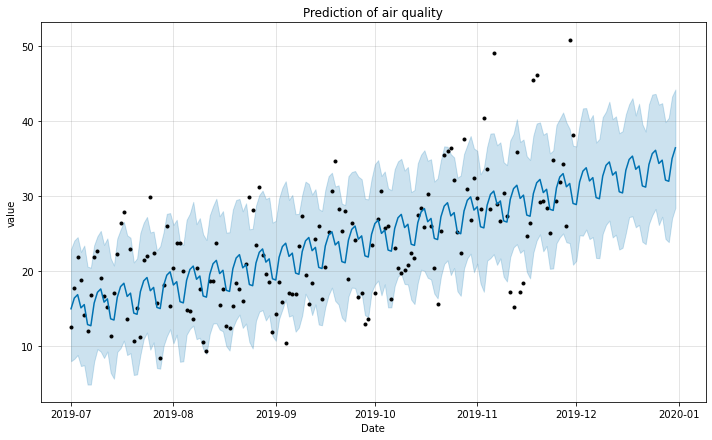

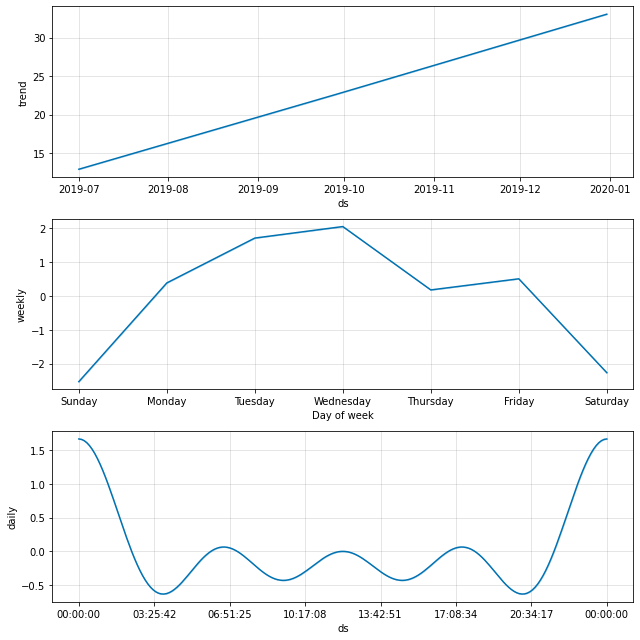

INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-09-20 00:00:00 and 2019-10-30 00:00:00


153    28.843434
154    31.864785
155    33.298024
156    33.748347
157    31.991134
158    32.429824
159    29.773146
160    29.619688
161    32.641038
162    34.074278
163    34.524601
164    32.767388
165    33.206077
166    30.549399
167    30.395941
168    33.417292
169    34.850532
170    35.300855
171    33.543642
172    33.982331
173    31.325653
174    31.172195
175    34.193546
176    35.626785
177    36.077108
178    34.319895
179    34.758585
180    32.101907
181    31.948449
182    34.969799
183    36.403039
Name: yhat, dtype: float64 153    46.181105
154    52.481502
155    43.995351
156    37.711571
157    27.876005
158    16.705599
159    20.386900
160    14.207916
161    29.844561
162    19.559816
163    29.196148
164    29.577194
165    19.291133
166    17.793278
167    19.758173
168    35.175822
169    48.116212
170    34.139281
171    23.322040
172    33.044729
173    33.556940
174    34.582989
175    21.630847
176    23.194696
177    25.663512
178    23.245304
179 

  0%|          | 0/5 [00:00<?, ?it/s]

   horizon         mse       rmse       mae      mape     mdape  coverage
0   3 days   37.692062   6.139386  5.280558  0.195036  0.148897  0.666667
1   4 days   60.787082   7.796607  6.360278  0.201782  0.154368  0.600000
2   5 days   57.679637   7.594711  6.244534  0.198083  0.185755  0.666667
3   6 days   47.197037   6.870010  5.432666  0.190677  0.185755  0.800000
4   7 days   50.556693   7.110323  5.235295  0.189409  0.196938  0.866667
5   8 days   56.643643   7.526197  5.344286  0.210619  0.213597  0.800000
6   9 days   56.846057   7.539632  5.314872  0.209057  0.180154  0.800000
7  10 days   26.322297   5.130526  3.991399  0.184915  0.164256  0.866667
8  11 days   18.409012   4.290572  3.696704  0.172477  0.134962  0.866667
9  12 days   31.101166   5.576842  4.787790  0.205555  0.138464  0.733333
10 13 days   56.009384   7.483942  6.450932  0.275526  0.219413  0.533333
11 14 days   87.034968   9.329253  7.974689  0.294173  0.219413  0.466667
12 15 days   91.648911   9.573344  8.3

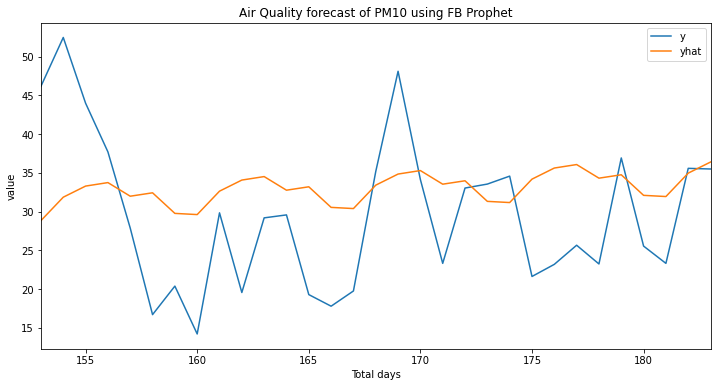

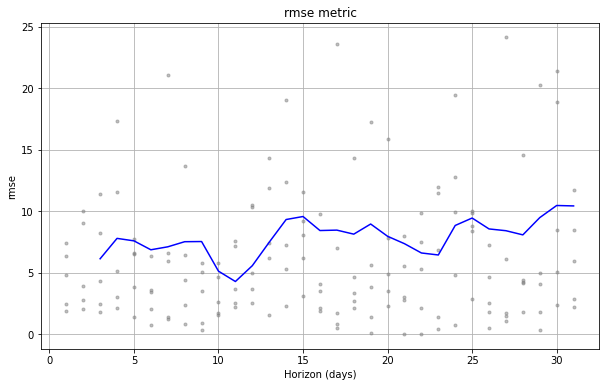

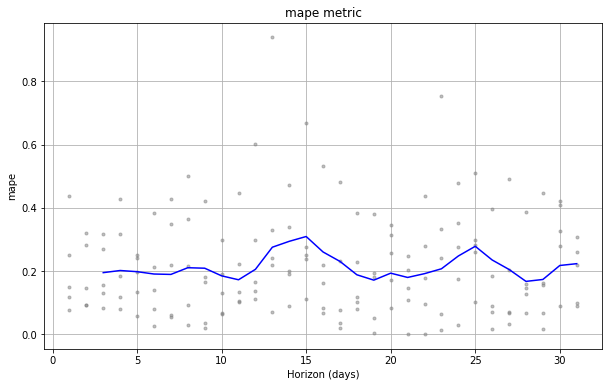

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,37.692062,6.139386,5.280558,0.195036,0.148897,0.666667
1,4 days,60.787082,7.796607,6.360278,0.201782,0.154368,0.600000
2,5 days,57.679637,7.594711,6.244534,0.198083,0.185755,0.666667
3,6 days,47.197037,6.870010,5.432666,0.190677,0.185755,0.800000
4,7 days,50.556693,7.110323,5.235295,0.189409,0.196938,0.866667
5,8 days,56.643643,7.526197,5.344286,0.210619,0.213597,0.800000
6,9 days,56.846057,7.539632,5.314872,0.209057,0.180154,0.800000
7,10 days,26.322297,5.130526,3.991399,0.184915,0.164256,0.866667
8,11 days,18.409012,4.290572,3.696704,0.172477,0.134962,0.866667
9,12 days,31.101166,5.576842,4.787790,0.205555,0.138464,0.733333


In [10]:
#PM10 prediction of MCU
predict_FB_step1(df_pm10,153,31)

In [11]:
#NO2 data of MCU
mcu_no2 = mcu_data.drop('PostCodes', 1)
mcu_no2 = mcu_no2.drop('PM10', 1)
#mcu_no2 = mcu_no2.sort_values(by=['timestamp'],ascending=True)
mcu_no2

,timestamp,NO2,date,hour
0,01-01-2020 00:00:00,56.77936,2020-01-01,0
1,01-01-2020 00:00:00,17.40000,2020-01-01,0
2,01-01-2020 00:00:00,24.20000,2020-01-01,0
3,01-01-2020 00:00:00,17.97500,2020-01-01,0
4,01-01-2020 00:00:00,12.60000,2020-01-01,0
...,...,...,...,...
89429,31-12-2019 23:00:00,28.00000,2019-12-31,23
89430,31-12-2019 23:00:00,21.25600,2019-12-31,23
89431,31-12-2019 23:00:00,34.00236,2019-12-31,23
89432,31-12-2019 23:00:00,18.40000,2019-12-31,23


In [12]:
mcu__no2_df = mcu_no2[(mcu_no2['date'] <= '2019-12-31')]
mcu__no2_df

,timestamp,NO2,date,hour
1524,01-07-2019 00:00:00,13.27172,2019-07-01,0
1525,01-07-2019 00:00:00,10.20000,2019-07-01,0
1526,01-07-2019 00:00:00,2.24205,2019-07-01,0
1527,01-07-2019 00:00:00,13.50000,2019-07-01,0
1528,01-07-2019 00:00:00,8.77500,2019-07-01,0
...,...,...,...,...
89429,31-12-2019 23:00:00,28.00000,2019-12-31,23
89430,31-12-2019 23:00:00,21.25600,2019-12-31,23
89431,31-12-2019 23:00:00,34.00236,2019-12-31,23
89432,31-12-2019 23:00:00,18.40000,2019-12-31,23


In [13]:
#df = mcu_df.rename(columns = {"date":"ds","PM10":"y"}) 
#df['day'] = pd.to_datetime(df['ds']).dt.date
df_no2 = mcu__no2_df.groupby(["date"])['NO2'].mean().reset_index()
df_no2 = df_no2.rename(columns = {"date":"ds","NO2":"y"}) 
df_no2

,ds,y
0,2019-07-01,15.958031
1,2019-07-02,20.281922
2,2019-07-03,24.626909
3,2019-07-04,21.133151
4,2019-07-05,18.343818
...,...,...
179,2019-12-27,28.518860
180,2019-12-28,23.767044
181,2019-12-29,22.197187
182,2019-12-30,32.939823


In [14]:
## complete FB_Prophet fitting, plotting ETS components from model, finding performance metrics using cross validation and returing horizon based cross validation metrics on 
## a single training dataset -  cross validated on testing data only
def predict_FB_step1(df,break_index, per):
    df_FB = df[:break_index]
    print('start and end date of training dataset :', df_FB['ds'].head(1),df_FB['ds'].tail(1))
    
    test = df[break_index:break_index+per]
    print('start and end date of testing dataset :', test['ds'].head(1),test['ds'].tail(1))  
    print(test)
    
    from fbprophet import Prophet
    #The Prophet class (model)
    fbp = Prophet(daily_seasonality = True) 
    #Fit the model 
    fbp.fit(df_FB)
    
    # We need to specify the number of days in future
    # We'll be predicting the full 2021 stock prices
    fut = fbp.make_future_dataframe(periods=per) 
    forecast = fbp.predict(fut)
    
    from fbprophet.plot import plot_plotly, plot_components_plotly
    # A better plot than the simple matplotlib
    forecast_plot = plot_plotly(fbp, forecast)
    forecast_plot.show()
    
    fbp.plot(forecast)
    plt.title("Prediction of air quality")
    plt.xlabel("Date")
    plt.ylabel("value")
    plt.show()
    
    fbp.plot_components(forecast)
    plt.show()
    
    from statsmodels.tools.eval_measures import rmse
    predictions = forecast.tail(per)
    
    #predictions = forecast.iloc[-per:]['yhat']
    print(predictions['yhat'],test['y'])
    

    
    
    # Plot predictions against known values
    import matplotlib.ticker as ticker
    #formatter = ticker.StrMethodFormatter('{x:,.0f}')
    title = 'Air Quality forecast of NO2 using FB Prophet'
    ylabel='value'
    xlabel='Total days'
    ax = test['y'].plot(legend=True,figsize=(12,6),title=title)
    predictions['yhat'].plot(legend=True)
    ax.autoscale(axis='x',tight=True)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    #ax.yaxis.set_major_formatter(formatter);
    
    from fbprophet.diagnostics import cross_validation,performance_metrics
    from fbprophet.plot import plot_cross_validation_metric
    
    length = round(len(df_FB)/24,0)
    print(length)
    
    # Initial length of df_FB training period
    initial = 80
    initial = str(initial) + ' days'
    # Fold every length of df_FB years
    period = 10
    period = str(period) + ' days'
    # Forecast per days into the future
    horizon = per
    horizon = str(horizon) + ' days'
    #, 
    df_cv = cross_validation(fbp,initial=initial, period=period,  horizon = horizon)
    df_cv
    performance_metrics = performance_metrics(df_cv)
    print(performance_metrics)
    
    plot_cross_validation_metric(df_cv, metric='rmse');
    plt.title("rmse metric")
    plt.show()
    
    plot_cross_validation_metric(df_cv, metric='mape');
    plt.title("mape metric")
    plt.show()
    performance_metrics.to_csv("performance_metrics_no2.csv") 
    !cp performance_metrics_no2.csv "/content/drive/MyDrive/Colab Notebooks"
    return performance_metrics

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


start and end date of training dataset : 0    2019-07-01
Name: ds, dtype: object 152    2019-11-30
Name: ds, dtype: object
start and end date of testing dataset : 153    2019-12-01
Name: ds, dtype: object 183    2019-12-31
Name: ds, dtype: object
             ds          y
153  2019-12-01  39.502645
154  2019-12-02  52.466549
155  2019-12-03  39.665819
156  2019-12-04  33.749942
157  2019-12-05  20.213880
158  2019-12-06  18.204238
159  2019-12-07  18.760879
160  2019-12-08  14.708674
161  2019-12-09  32.056964
162  2019-12-10  19.932664
163  2019-12-11  24.736764
164  2019-12-12  24.428870
165  2019-12-13  21.739775
166  2019-12-14  20.363058
167  2019-12-15  15.901434
168  2019-12-16  28.656456
169  2019-12-17  41.784354
170  2019-12-18  27.006997
171  2019-12-19  18.393957
172  2019-12-20  29.536339
173  2019-12-21  19.886977
174  2019-12-22  22.334338
175  2019-12-23  20.525723
176  2019-12-24  19.700041
177  2019-12-25  22.067107
178  2019-12-26  19.082094
179  2019-12-27  28.5188

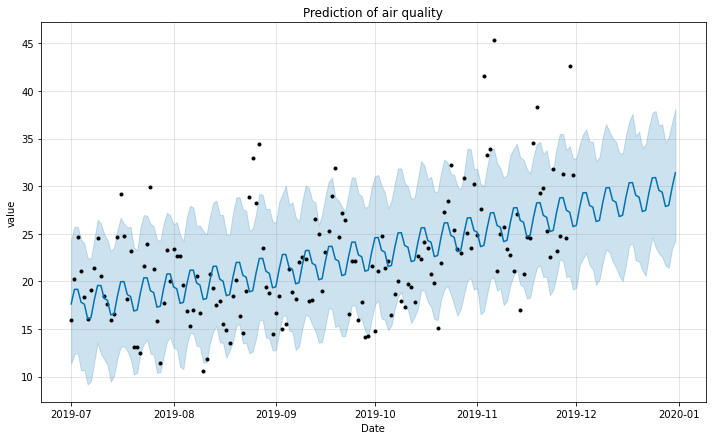

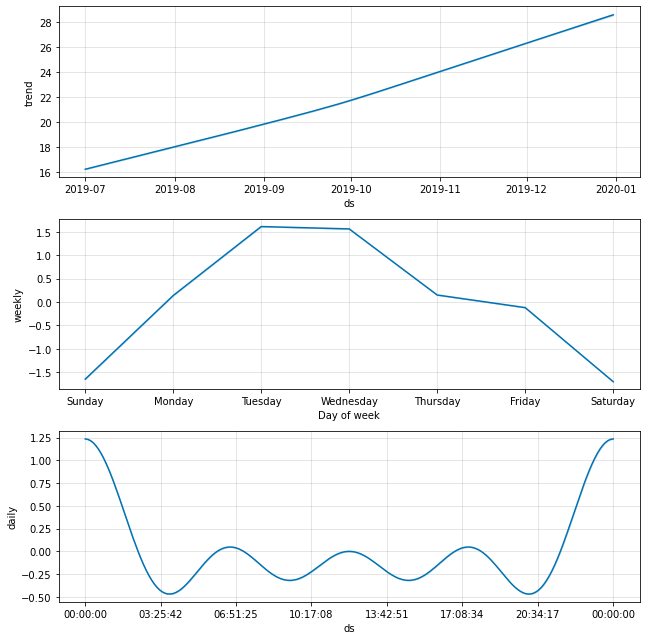

INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-09-20 00:00:00 and 2019-10-30 00:00:00


153    25.888189
154    27.751223
155    29.301226
156    29.326297
157    27.988585
158    27.794426
159    26.286643
160    26.415190
161    28.278225
162    29.828228
163    29.853298
164    28.515587
165    28.321427
166    26.813645
167    26.942192
168    28.805226
169    30.355229
170    30.380300
171    29.042588
172    28.848429
173    27.340646
174    27.469193
175    29.332228
176    30.882231
177    30.907302
178    29.569590
179    29.375430
180    27.867648
181    27.996195
182    29.859229
183    31.409232
Name: yhat, dtype: float64 153    39.502645
154    52.466549
155    39.665819
156    33.749942
157    20.213880
158    18.204238
159    18.760879
160    14.708674
161    32.056964
162    19.932664
163    24.736764
164    24.428870
165    21.739775
166    20.363058
167    15.901434
168    28.656456
169    41.784354
170    27.006997
171    18.393957
172    29.536339
173    19.886977
174    22.334338
175    20.525723
176    19.700041
177    22.067107
178    19.082094
179 

  0%|          | 0/5 [00:00<?, ?it/s]

   horizon        mse      rmse       mae      mape     mdape  coverage
0   3 days  25.903910  5.089588  4.212837  0.185057  0.173627  0.600000
1   4 days  51.560200  7.180543  4.903391  0.171715  0.104971  0.666667
2   5 days  55.249018  7.432968  5.099987  0.175111  0.116272  0.666667
3   6 days  58.225623  7.630572  5.354629  0.190189  0.172795  0.666667
4   7 days  54.267048  7.366617  5.262827  0.196585  0.176863  0.733333
5   8 days  55.974135  7.481586  5.576085  0.225228  0.191256  0.733333
6   9 days  48.899133  6.992791  4.861090  0.203497  0.191256  0.866667
7  10 days  18.890108  4.346275  3.578823  0.182395  0.172118  0.933333
8  11 days  20.463518  4.523662  3.673283  0.192297  0.122864  0.866667
9  12 days  18.927573  4.350583  3.399068  0.165406  0.122864  0.866667
10 13 days  23.627234  4.860785  3.841201  0.170193  0.122864  0.733333
11 14 days  54.731311  7.398061  4.789379  0.161103  0.109976  0.733333
12 15 days  67.812477  8.234833  5.924412  0.208446  0.167220  0

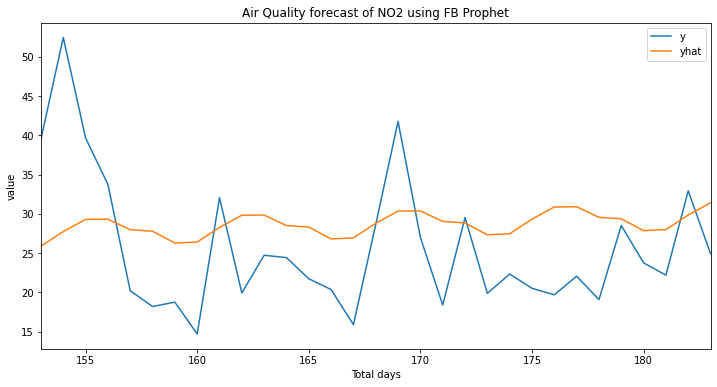

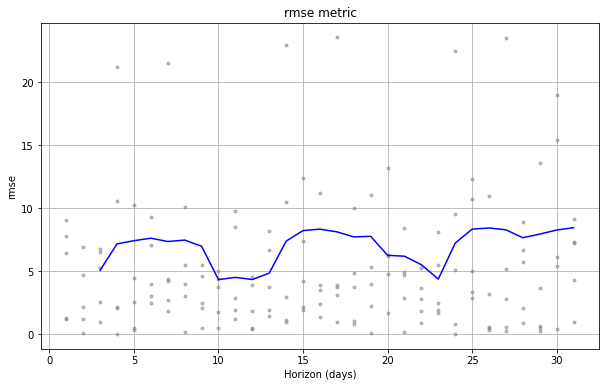

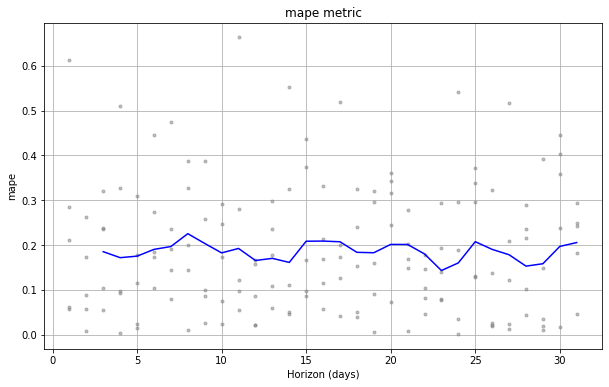

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,25.903910,5.089588,4.212837,0.185057,0.173627,0.600000
1,4 days,51.560200,7.180543,4.903391,0.171715,0.104971,0.666667
2,5 days,55.249018,7.432968,5.099987,0.175111,0.116272,0.666667
3,6 days,58.225623,7.630572,5.354629,0.190189,0.172795,0.666667
4,7 days,54.267048,7.366617,5.262827,0.196585,0.176863,0.733333
5,8 days,55.974135,7.481586,5.576085,0.225228,0.191256,0.733333
6,9 days,48.899133,6.992791,4.861090,0.203497,0.191256,0.866667
7,10 days,18.890108,4.346275,3.578823,0.182395,0.172118,0.933333
8,11 days,20.463518,4.523662,3.673283,0.192297,0.122864,0.866667
9,12 days,18.927573,4.350583,3.399068,0.165406,0.122864,0.866667


In [15]:
#NO2 prediction of MCU
predict_FB_step1(df_no2,153,31)

In [105]:
pf_metric_pm10 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/performance_metrics_pm10.csv")
pf_metric_pm10

,Unnamed: 0,horizon,mse,rmse,mae,mape,mdape,coverage
0,0,3 days,59.595994,7.719844,6.296003,0.199922,0.153882,0.600000
1,1,4 days,56.825210,7.538250,6.188686,0.196516,0.182740,0.600000
2,2,5 days,46.508493,6.819714,5.378362,0.188981,0.182740,0.666667
3,3,6 days,50.287627,7.091377,5.218671,0.189366,0.194271,0.666667
4,4,7 days,56.321140,7.504741,5.318390,0.211868,0.181647,0.666667
5,5,8 days,56.424744,7.511641,5.294289,0.211071,0.169684,0.733333
6,6,9 days,25.912399,5.090422,3.920946,0.184685,0.156314,0.866667
7,7,10 days,18.142600,4.259413,3.635067,0.171159,0.131246,0.866667
8,8,11 days,30.775261,5.547546,4.709438,0.203340,0.131246,0.733333
9,9,12 days,55.595712,7.456253,6.402701,0.274809,0.214747,0.533333


In [107]:
pf_metric_pm10 = pf_metric_pm10.filter(['horizon','rmse','mape'], axis=1)
pf_metric_pm10['Variable'] = 'PM10'
pf_metric_pm10['City'] = 'MCU'
pf_metric_pm10

,horizon,rmse,mape,Variable,City
0,3 days,7.719844,0.199922,PM10,MCU
1,4 days,7.538250,0.196516,PM10,MCU
2,5 days,6.819714,0.188981,PM10,MCU
3,6 days,7.091377,0.189366,PM10,MCU
4,7 days,7.504741,0.211868,PM10,MCU
5,8 days,7.511641,0.211071,PM10,MCU
6,9 days,5.090422,0.184685,PM10,MCU
7,10 days,4.259413,0.171159,PM10,MCU
8,11 days,5.547546,0.203340,PM10,MCU
9,12 days,7.456253,0.274809,PM10,MCU


In [112]:
pf_metric_no2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/performance_metrics_no2.csv")
pf_metric_no2

,Unnamed: 0,horizon,mse,rmse,mae,mape,mdape,coverage
0,0,3 days,50.109610,7.078814,4.839532,0.170210,0.115906,0.666667
1,1,4 days,53.965224,7.346103,5.110352,0.177006,0.128454,0.666667
2,2,5 days,56.801050,7.536647,5.325372,0.190084,0.161797,0.666667
3,3,6 days,52.995031,7.279769,5.207070,0.195149,0.167001,0.733333
4,4,7 days,55.123495,7.424520,5.525222,0.225355,0.172303,0.666667
5,5,8 days,48.174544,6.940788,4.801178,0.203344,0.172303,0.800000
6,6,9 days,18.541360,4.305968,3.520012,0.181873,0.162849,0.866667
7,7,10 days,20.001929,4.472352,3.572109,0.188848,0.112670,0.866667
8,8,11 days,18.547842,4.306721,3.338611,0.163294,0.112670,0.866667
9,9,12 days,23.293943,4.826380,3.765204,0.167455,0.112670,0.733333


In [113]:
pf_metric_no2 = pf_metric_no2.filter(['horizon','rmse','mape'], axis=1)
pf_metric_no2['Variable'] = 'NO2'
pf_metric_no2['City'] = 'MCU'
pf_metric_no2

,horizon,rmse,mape,Variable,City
0,3 days,7.078814,0.170210,NO2,MCU
1,4 days,7.346103,0.177006,NO2,MCU
2,5 days,7.536647,0.190084,NO2,MCU
3,6 days,7.279769,0.195149,NO2,MCU
4,7 days,7.424520,0.225355,NO2,MCU
5,8 days,6.940788,0.203344,NO2,MCU
6,9 days,4.305968,0.181873,NO2,MCU
7,10 days,4.472352,0.188848,NO2,MCU
8,11 days,4.306721,0.163294,NO2,MCU
9,12 days,4.826380,0.167455,NO2,MCU


In [116]:
pf_metric_mcu = pd.concat([pf_metric_no2, pf_metric_pm10])
pf_metric_mcu = pf_metric_mcu.reset_index()
pf_metric_mcu = pf_metric_mcu.drop('index', axis=1)
pf_metric_mcu

,horizon,rmse,mape,Variable,City
0,3 days,7.078814,0.170210,NO2,MCU
1,4 days,7.346103,0.177006,NO2,MCU
2,5 days,7.536647,0.190084,NO2,MCU
3,6 days,7.279769,0.195149,NO2,MCU
4,7 days,7.424520,0.225355,NO2,MCU
5,8 days,6.940788,0.203344,NO2,MCU
6,9 days,4.305968,0.181873,NO2,MCU
7,10 days,4.472352,0.188848,NO2,MCU
8,11 days,4.306721,0.163294,NO2,MCU
9,12 days,4.826380,0.167455,NO2,MCU


In [117]:
pf_metric_mcu.to_csv("pf_metric_mcu.csv") 
!cp pf_metric_mcu.csv "/content/drive/MyDrive/Colab Notebooks"

Getting the performance metrics of both mcu and ncl

In [118]:
pf_mcu = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/pf_metric_mcu.csv")
pf_mcu

,Unnamed: 0,horizon,rmse,mape,Variable,City
0,0,3 days,7.078814,0.170210,NO2,MCU
1,1,4 days,7.346103,0.177006,NO2,MCU
2,2,5 days,7.536647,0.190084,NO2,MCU
3,3,6 days,7.279769,0.195149,NO2,MCU
4,4,7 days,7.424520,0.225355,NO2,MCU
5,5,8 days,6.940788,0.203344,NO2,MCU
6,6,9 days,4.305968,0.181873,NO2,MCU
7,7,10 days,4.472352,0.188848,NO2,MCU
8,8,11 days,4.306721,0.163294,NO2,MCU
9,9,12 days,4.826380,0.167455,NO2,MCU


In [119]:
pf_ncl = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/pf_metric_ncl.csv")
pf_ncl

,Unnamed: 0,horizon,rmse,mape,Variable,City
0,0,2 days,17.925196,0.519708,NO2,NCL
1,1,3 days,17.683514,0.483509,NO2,NCL
2,2,4 days,18.262088,0.485106,NO2,NCL
3,3,5 days,14.911943,0.355284,NO2,NCL
4,4,6 days,9.341335,0.185393,NO2,NCL
5,5,7 days,6.412135,0.130121,NO2,NCL
6,6,8 days,10.608931,0.222642,NO2,NCL
7,7,9 days,14.020518,0.351705,NO2,NCL
8,8,10 days,14.674147,0.364902,NO2,NCL
9,9,11 days,15.281444,0.373666,NO2,NCL


In [122]:
pf_metric = pd.concat([pf_mcu, pf_ncl])
pf_metric = pf_metric.drop('Unnamed: 0', axis=1)
pf_metric = pf_metric.reset_index()
pf_metric = pf_metric.drop('index', axis=1)
pf_metric

,horizon,rmse,mape,Variable,City
0,3 days,7.078814,0.170210,NO2,MCU
1,4 days,7.346103,0.177006,NO2,MCU
2,5 days,7.536647,0.190084,NO2,MCU
3,6 days,7.279769,0.195149,NO2,MCU
4,7 days,7.424520,0.225355,NO2,MCU
...,...,...,...,...,...
109,26 days,5.197712,0.580534,PM10,NCL
110,27 days,5.052307,0.571549,PM10,NCL
111,28 days,5.545235,0.732473,PM10,NCL
112,29 days,7.030328,1.096888,PM10,NCL


In [123]:
pf_metric.to_csv("pf_metric.csv") 
!cp pf_metric.csv "/content/drive/MyDrive/Colab Notebooks"